In [1]:
from __future__ import division
import sys, os

where = "/afs/cern.ch/user/o/oeftiger/w/private/"
# BIN = where + "git/PyHEADTAIL-lxblaster/"
BIN = where + "git/PyHEADTAIL/"
sys.path.append(BIN)
BIN = where + "git/PyPIC-experimental"
sys.path.append(BIN)
BIN = where + "git"
sys.path.append(BIN)

import copy

In [2]:
import numpy as np
from scipy.constants import m_p, c, e
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)

from PyPIC.meshing import UniformMesh1D

from pycuda.autoinit import context
from pycuda import gpuarray
from pycuda import cumath

import PyHEADTAIL
import PyHEADTAIL.gpu

from PyHEADTAIL.particles.particles import Particles
from PyHEADTAIL.gpu.slicing import MeshSlicer
from PyHEADTAIL.trackers.simple_long_tracking import LinearMap
from PyHEADTAIL.particles.generators import generate_Gaussian6DTwiss

from PyCERNmachines.CERNmachines import SPS

PyHEADTAIL v1.4.1-23-gf8be831a76-dirty




In [3]:
# general simulation parameters
n_segments = 250

# beam parameters
charge = e
mass = m_p
gamma = 27.72855209 # 26 GeV injection
intensity = 2.5e11 * 0.5
epsn_x = 2.5e-6 # in [m*rad]
epsn_y = 2.5e-6 # in [m*rad]
sig_z = 0.23 # in [m]

#simulation parameters
macroparticlenumber = 2*1024*1024
 #must be multiple of nslices
particlenumber_per_mp = intensity/macroparticlenumber

#create a params for slicers
nslices = 256
z_cuts = (-20.,30.) #asymmetric to check uniform_charge_slicer
n_sigma_z = 5

In [4]:
machine = SPS(n_segments=n_segments, machine_configuration='Q20-injection')

Synchrotron init. From kwargs: machine_configuration = 'Q20-injection'
Synchrotron init. From kwargs: n_segments = 250


In [5]:
def create_bunch(z_min=-1, z_max=1):
    z = np.linspace(z_min, z_max, num=macroparticlenumber)
    y = np.copy(z)
    x = np.copy(z)
    xp = np.linspace(-0.5, 0.5, num=macroparticlenumber)
    yp = np.copy(xp)
    dp = np.copy(xp)
    coords_n_momenta_dict = {
        'x': x, 'y': y, 'z': z,
        'xp': xp, 'yp': yp, 'dp': dp
    }

    #create a bunch
    return Particles(
        macroparticlenumber, particlenumber_per_mp, e, m_p,
        machine.circumference, gamma, coords_n_momenta_dict
    )
def create_gaussian_bunch():
    return machine.generate_6D_Gaussian_bunch_matched(
        n_macroparticles=macroparticlenumber,
        intensity=intensity,
        epsn_x=epsn_x,
        epsn_y=epsn_y,
        sigma_z=sig_z
    )

In [6]:
def create_mesh(nslices=nslices, z_cuts=z_cuts):
    return UniformMesh1D(z_cuts[0],
                         np.diff(z_cuts)[0] / nslices,
                         nslices,
                         mathlib=cumath)

In [7]:
beam = create_bunch()

In [8]:
mesh = create_mesh()
basic_slicer = MeshSlicer(mesh, context)
basic_slice_set = basic_slicer.slice(beam)

In [9]:
basic_slicer.get_long_cuts(beam)

(-20.0, 30.0)

In [10]:
unif_bin_slicer = MeshSlicer(mesh, context)
unif_bin_slicer2 = MeshSlicer(mesh, context)
assert unif_bin_slicer == unif_bin_slicer2
assert not unif_bin_slicer != unif_bin_slicer2

In [11]:
unif_bin_slicer = MeshSlicer(mesh, context)
unif_bin_slicer2 = MeshSlicer(create_mesh(nslices=nslices+1), context)
assert unif_bin_slicer != unif_bin_slicer2
assert not unif_bin_slicer == unif_bin_slicer2

In [12]:
z_min, z_max = -2., 2.
bunch = create_bunch(z_min=z_min, z_max=z_max)
z_cuts = (z_min-1, z_max+1)

mesh = create_mesh(z_cuts=z_cuts)

slice_set = MeshSlicer(mesh, context).slice(bunch)
n_particles = gpuarray.sum(slice_set.n_macroparticles_per_slice).get()
assert (macroparticlenumber == n_particles)

In [13]:
basic_slicer.add_statistics(
    basic_slice_set, beam, True,
    basic_slice_set.lower_bounds,
    basic_slice_set.upper_bounds
)
basic_slice_set.mean_x
basic_slice_set.sigma_x
print 'works'

works


In [14]:
z_min, z_max = -2., 2.
bunch = create_bunch(z_min=z_min, z_max=z_max)
z_cuts = (z_min+1, z_max-1)

mesh = create_mesh(z_cuts=z_cuts)

slice_set = MeshSlicer(mesh, context).slice(bunch)
n_particles = gpuarray.sum(slice_set.n_macroparticles_per_slice).get()
assert n_particles == bunch.macroparticlenumber/2

In [15]:
beam = create_gaussian_bunch()
mesh = create_mesh(z_cuts=(min(beam.z.get()), max(beam.z.get())*(1+1e-15)))
slice_set = MeshSlicer(mesh, context).slice(beam)

*** Maximum RMS bunch length 0.235788291837m.
... distance to target bunch length: -2.4290e-02
... distance to target bunch length: -2.4255e-02
... distance to target bunch length: -9.4232e-03
... distance to target bunch length: -5.0846e-03
... distance to target bunch length: -2.0166e-03
... distance to target bunch length: -6.6153e-04
... distance to target bunch length: -1.2571e-04
... distance to target bunch length: -9.7555e-06
... distance to target bunch length: -1.5712e-07
... distance to target bunch length: -1.9993e-10
--> Bunch length: 0.23
--> Emittance: 0.407764779947


In [16]:
beam_ram = copy.copy(beam)
for coord in beam_ram.coords_n_momenta:
    setattr(beam_ram, coord, getattr(beam_ram, coord).get())
beam_ram.id = beam_ram.id.get()

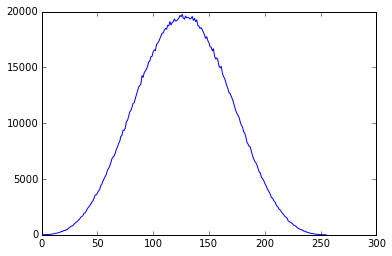

In [17]:
plt.plot(slice_set.n_macroparticles_per_slice.get())

In [18]:
from PyHEADTAIL.particles.slicing import UniformBinSlicer
slice_set_ram = beam_ram.get_slices(UniformBinSlicer(
        nslices, z_cuts=(float(slice_set.z_cut_tail), float(slice_set.z_cut_head))))

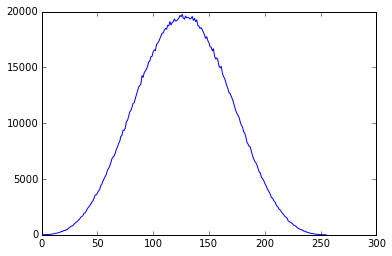

In [19]:
plt.plot(slice_set_ram.n_macroparticles_per_slice)

In [20]:
np.all(beam.z.get() == beam_ram.z)

True

In [21]:
np.all(slice_set.n_macroparticles_per_slice.get() == slice_set_ram.n_macroparticles_per_slice)

True

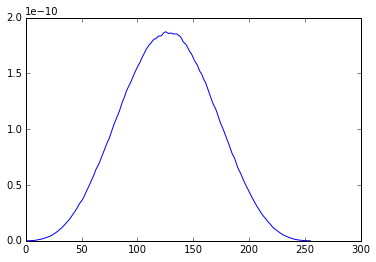

In [22]:
plt.plot(slice_set_ram.lambda_bins(1))

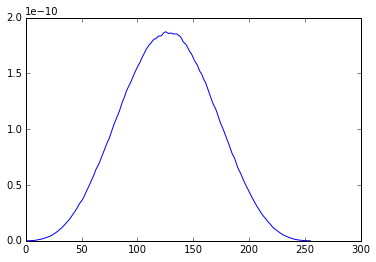

In [23]:
plt.plot(slice_set.lambda_bins(1).get())

In [24]:
np.allclose(slice_set_ram.lambda_bins(1), slice_set.lambda_bins(1).get())

True

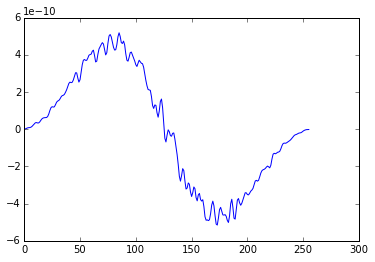

In [31]:
plt.plot(slice_set_ram.lambda_prime_bins(1))

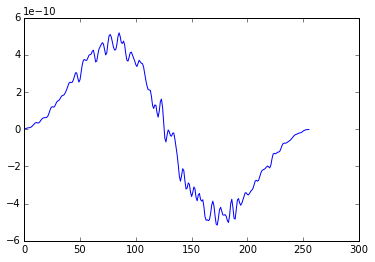

In [26]:
plt.plot(slice_set.lambda_prime_bins(1).get())

In [27]:
np.allclose(slice_set_ram.lambda_prime_bins(1, False, False) / slice_set_ram.charge_per_mp,
            slice_set.lambda_prime_bins(1, False, False).get() / slice_set.charge_per_mp)

True